<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
%run plot_functions/plot_settings.py

# HM coupling in 1D -- liquefaction test

## Strong form

\begin{align}
    0 &= \partial_z \sigma_{zz} + \gamma_\text{r} = \partial_z (\sigma_{zz}' - p) + \gamma_\text{r} = \partial_z \left[ E_\text{s} \partial_z u_z \right] - \partial_z p + \gamma_\text{r}\\
    0 &= \partial_z (\dot{u}_z + q_z) = \partial_z \dot{u}_z - \partial_z \left[ \frac{k}{\mu} \left( \partial_z p - \gamma_\text{w} \right) \right]
\end{align}

## Weak form

The displacements can have (the essential/Dirichlet) boundary conditions in the form:

$$
    u = \bar{u}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta u$ (virtual displacement) which vanishes where the displacement is given

$$
    \delta u = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form of the equilibrium conditions (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[\partial_z \sigma_{zz} + \gamma_\text{r} \right] \delta u\, \text{d}z
   \\
   &= \int \limits_0^H \left[\frac{\partial}{\partial z} \left(\sigma_{zz} \delta u \right) - \partial_z \delta u \ \sigma_{zz}\, \partial_z u_z + \gamma_\text{r} \delta u \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ \sigma_{zz} \delta u \right]_0^H + \int \limits_0^H \gamma_\text{r} \delta u \text{d}z = \int \limits_0^H \partial_z \delta u\ (\sigma_{zz}' - p)  \, \text{d}z
$$
which is recognised as the principal of virtual work: $\delta W_\text{ext} = \delta W_\text{int}$.

The pore pressure can have (the essential/Dirichlet) boundary conditions in the form:

$$
    p = \bar{p}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta p$ which vanishes where the pressure is given

$$
    \delta p = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form of the equilibrium conditions (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[\partial_z (\dot{u}_z + q_z) \right] \delta p\, \text{d}z
   \\
   &= \int \limits_0^H \left[ \partial_z (\delta p\, q_z) - q_z \partial_z \delta p + \partial_z \dot{u}_z \delta p \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ q_z \delta p \right]_0^H + \int \limits_0^H \left[ \delta p\, \partial_z \dot{u}_z - \partial_z \delta p\ q_z \right] \, \text{d}z
$$

## Finite elements in 1D

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [23]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [24]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_node_ids_u(num_iterations):
    sequence = []
    last_element = 0

    for i in range(num_iterations):
        if i == 0:
            triplet = (0, 1, 2)
        elif i == 1:
            triplet = (2, 5, 6)
        else:
            a = last_element
            b = a + 2
            c = b + 1
            triplet = (a, b, c)
        
        sequence.append(triplet)
        last_element = triplet[-1]
    return sequence

def generate_node_ids_p(num_iterations):
    sequence = []
    last_element = 3  # Start with the first element as 3

    for i in range(num_iterations):
        if i == 0:
            pair = (3, 4)
        else:
            a = last_element
            b = a + 3
            pair = (a, b)
        
        sequence.append(pair)
        last_element = pair[-1]
    return sequence

def generate_mesh(domain_length,nelems,nodes_per_elem):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    if (nodes_per_elem == 3):
        node_ids = generate_node_ids_u(nelems)
    else:
        node_ids = generate_node_ids_p(nelems)
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        node_start_id = (2*nodes_per_elem-2)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         node_ids[i]))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [25]:
number_of_elements = 20
L = 10.
nodes_per_element = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element)
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1)
solution = np.append(solution_u,solution_p)

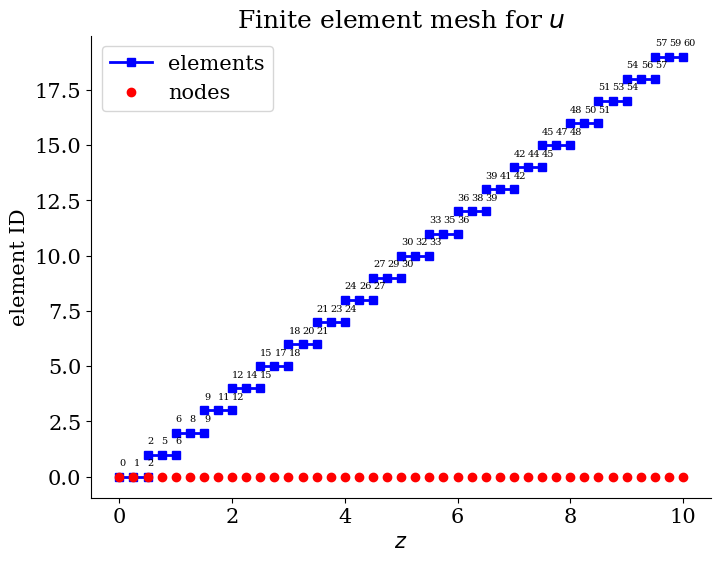

In [26]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh for $u$')
for i,elem in enumerate(elements_u):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_u, [0]*len(nodes_u), 'ro ', label='nodes')
plt.legend();

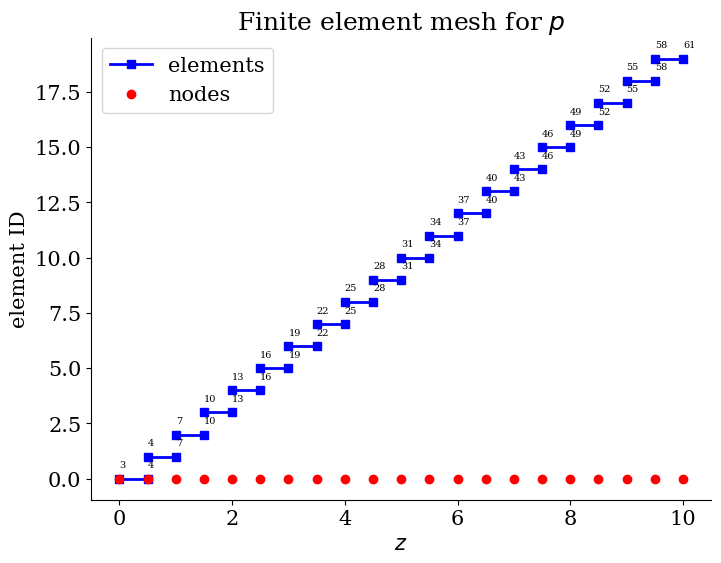

In [27]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh for $p$')
for i,elem in enumerate(elements_p):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_p, [0]*len(nodes_p), 'ro ', label='nodes')
plt.legend();

In [28]:
#N
def shape_function(element_order,xi):
    if (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 2): #-1,1
        return np.array([-0.5, 0.5])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac


## Discretization of virtual work (weak form)

The discretized system is given as

\begin{align}
    {\sigma}_{zz}(z=H)\delta_{in_\text{n}} - {\sigma}_{zz}(z=0) \delta_{i0} + \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \gamma_\text{r} N^u_i \det J \, \text{d}\xi &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^u (\sigma_{zz}' - p)\det J  \, \text{d}\xi
    \\
    {q}_{z}(z=H)\delta_{in_\text{n}} - {q}_{z}(z=0) \delta_{i0} &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^p q_z \det J  \, \text{d}\xi - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} N_i^p \frac{\partial_z u_z - \partial_z u_z^\text{prev}}{\Delta t} \det J  \, \text{d}\xi 
\end{align}

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_{i=1}^{n_\text{gp}} f(\xi_i) w_i 
$$

## Local assember

In [29]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    n=0.4
    return 26000.*(1.-n) + 10000.*n #kg/m³

def gamma_w():
    return 10000.

def Conductivity(z):
    return 1e-12/1e-3

In [ ]:
def local_assembler_res(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    element_order = elem_u._line_element__nnodes
    res_loc = np.zeros(2*element_order-1)
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(element_order,xi)
        N_p = shape_function(element_order-1,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(z_glob)
        k_over_mu = Conductivity(z_glob)
        #evaluation of local body force contributions
        gr = gamma_r(z_glob)
        gw = gamma_w()
        
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p) - gw)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        e_vol_dot = (np.dot(dN_u_dX,sol_u) - np.dot(dN_u_dX,sol_u_prev)) / dt
           
        res_u = dN_u_dX*s_z - N_u*gr
        res_p = dN_p_dX*q_z - N_p * e_vol_dot
        
        #assembly of local RHS
        res_loc += np.block([res_u, res_p]) * w * detJ
    return res_loc

In [61]:
epsilon = lambda p: np.maximum(1e-8,1e-8*p)

# could use forward differences to safe one set of evaluations
def local_assembler_Jac(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    element_order = elem_u._line_element__nnodes
    Jac = np.zeros((2*element_order-1,2*element_order-1))
    r0 = local_assembler_res(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt)
    sol = np.append(sol_u,sol_p)
    for j in range(len(sol)):
        upper_up = np.copy(sol)
        eps = epsilon(upper_up[j])
        upper_up[j] += eps
        Jac[:,j] = (local_assembler_res(elem_u,elem_p,upper_up[0:len(sol_u)],
                                        upper_up[len(sol_u):],sol_u_prev,sol_p_prev,dt)
                    - r0)/eps
    return Jac, r0

In [62]:
elem_u = elements_u[1]
elem_p = elements_p[1]

sol_u = np.array([elem_u._line_element__global_ids[0], 
                  elem_u._line_element__global_ids[1], 
                  elem_u._line_element__global_ids[2]])

sol_p = np.array([elem_p._line_element__global_ids[0], 
                  elem_p._line_element__global_ids[1]])

In [63]:
local_assembler_res(elem_u,elem_p,sol_u,sol_p, sol_u*1.1,sol_p*1.1,1)

array([-1.33333496e+09,  1.06666014e+09,  2.66665027e+08,  2.66656673e-01,
        1.33343327e-01])

In [64]:
local_assembler_Jac(elem_u,elem_p,sol_u,sol_p, sol_u*1.1,sol_p*1.1,1)

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([-1.33333496e+09,  1.06666014e+09,  2.66665027e+08,  2.66656673e-01,
         1.33343327e-01]))

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [78]:
def global_assembler(nodes_u,elements_u,elements_p,solution,solution_prev,dt):
    K_glob = np.zeros((len(solution),len(solution)))
    b_glob = np.zeros(len(solution))
    for i,elem in enumerate(elements_u):
        #DOF table
        IDs_u = elem_u._line_element__global_ids
        IDs_p = elements_p[i]._line_element__global_ids
        #
        el_sol_u = np.array([solution[IDs_u[0]], solution[IDs_u[1]], solution[IDs_u[2]]])
        el_sol_u_prev = np.array([solution_prev[IDs_u[0]], solution_prev[IDs_u[1]], solution_prev[IDs_u[2]]])
        el_sol_p = np.array([solution[IDs_p[0]], solution[IDs_p[1]]])
        el_sol_p_prev = np.array([solution_prev[IDs_p[0]], solution_prev[IDs_p[1]]])
        
        K_i, b_i = local_assembler_Jac(elem,elements_p[i],el_sol_u,el_sol_p,el_sol_u_prev,el_sol_p_prev,dt)
        for j in range(3):
            b_glob[elem._line_element__global_ids[j]] += b_i[j]
            for k in range(3):
                K_glob[elem._line_element__global_ids[j],elem._line_element__global_ids[k]] += K_i[j,k]
        for j in range(2):
            b_glob[elements_p[i]._line_element__global_ids[j]] += b_i[j+3]
            for k in range(2):
                K_glob[elements_p[i]._line_element__global_ids[j],elements_p[i]._line_element__global_ids[k]] += K_i[j+3,k+3]
            
    return K_glob, b_glob

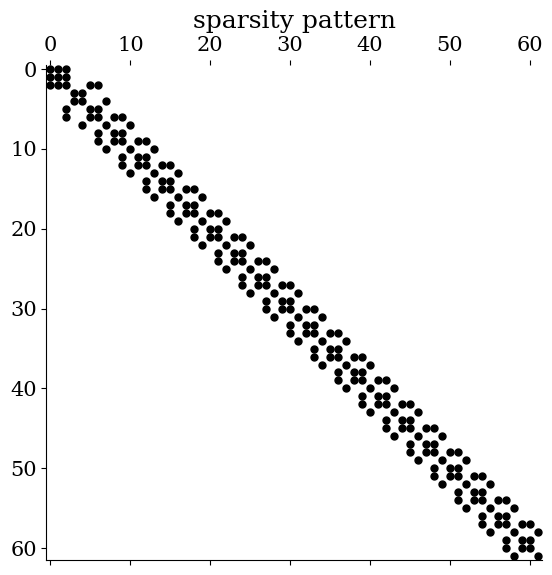

In [79]:
K, f = global_assembler(nodes_u,elements_u,elements_p,solution,solution*1.1,1)
plt.spy(K,marker='.')
plt.title('sparsity pattern')
plt.tight_layout()

## Application of boundary conditions

Now we apply the natural (Neumann, nodal force) and the essential (Dirichlet, nodal displacement) boundary conditions.

A nodal force $F_\text{bc}$ at node $m$ is simply added by
$$
    F^\text{ext}_i = \left(
        \begin{array}{c}
            F_0\\ F_1\\ \vdots\\ F_m \\ \vdots \\ F_{n_\text{n}}
        \end{array}
    \right)
     = F_i^\text{body} + F_\text{bc} \delta_{im} = F_i^\text{body} + F_\text{bc}
     \left(
        \begin{array}{c}
            0\\ 0\\ \vdots \\ 1 \\ \vdots \\ 0
        \end{array}
    \right)
$$

In [ ]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

A Dirichlet boundary condition is introduced via

$b_0 \leftarrow K_{0,0}(u_0 - \bar{u})$ so that $\Delta u_0 = \bar{u} - u_0$ and matrix condition number is not changed.

$b_{i \neq 0} \leftarrow b_{i\neq 0} - K_{i,0} (u_0 - \bar{u})$

$K_{0,i\neq 0} = K_{i\neq 0,0} \leftarrow 0$ 

This preserves $K_{ij} = K_{ji}$

In [ ]:
#adapted to incremental scheme
def apply_Dirichlet_bc(K_glob,b_glob,solution,node_id,value):
    c = K_glob[node_id,node_id]
    target = solution[node_id] - value
    
    for i in range(len(b_glob)):
        b_glob[i] -= K_glob[i,node_id] * target
        b_glob[node_id] = c*target #no increment
    K_glob[node_id,:] = 0.
    K_glob[:,node_id] = 0.
    
    if (c != 0):
        K_glob[node_id,node_id] = c
    else: 
        K_glob[node_id,node_id] = 1.
        c = 1.

    #solution[node_id] = value
    return K_glob, b_glob, solution

## Problem solution

We now perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

In [ ]:
f = apply_Neumann_bc(f,len(nodes)-1,0)

In [ ]:
K, f = apply_Dirichlet_bc(K, f, 0, -1.)

In [ ]:
solution = np.linalg.solve(K,f)

In [ ]:
reference_z = np.linspace(0,L,100)
reference_solution = ((reference_z/L)**2 - 2.*reference_z/L) * BodyForce(0) * L**2 / (2.*Stiffness(0))

In [ ]:
plt.ylabel('$z$ / m')
plt.xlabel('$-u_z$ / mm')
plt.title('Finite element solution')
plt.plot(-solution*1e3, nodes, 'ro-', label='FEM')
plt.plot(reference_solution*1e3, reference_z, ls='--', color='black', label='analytical')
plt.legend();